In [139]:
from sqlalchemy import create_engine
from api_keys import POSTGRES_PWD
import dill

import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

%matplotlib inline

# Summary

Michelle L. Gill  
2016/07/28  

The ability to predict Zika outbreaks is being modeled. For classification purposes, the threshold was initially set as the existence of any case of Zika.

A logistic regression classifier was trained with approximately 93% accuracy, however there are some class imbalance issues. (See confusion matrix below.)

Likewise, the RandomForest classifer needs some improvement:

![](./ROC.png)

## Input data

The input data include the following:

1. Zika outbreak data downloaded from this [GitHub repo](https://github.com/cdcepi/zika)
2. Scraped Latitude and longitude data for Zika outbreaks:

    * Google Maps API
    * Google Search
    * From [https://www.distancesto.com](https://www.distancesto.com)--this was a very forgiving search engine

3. Airport information for worldwide airports, including latitude and longitude scraped from [http://fallingrain.com](http://fallingrain.com)

4. Worldwide historical weather data, scraped from [http://wunderground.com](https://www.wunderground.com) by proximal airport code

5. Population density from NASA Socioeconomic Data and Applications Center (SEDAC), Gridded Population and Population Density of the World from [http://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density](http://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density)

6. *Aedes aegypti* and *Aedes albopictus* occurrences from [Dryad](http://dx.doi.org/10.5061/dryad.47v3c/1)

> Kraemer MUG, Sinka ME, Duda KA, Mylne A, Shearer FM, Brady OJ, Messina JP, Barker CM, Moore CG, Carvalho RG, Coelho GE, Van Bortel W, Hendrickx G, Schaffner F, Wint GRW, Elyazar IRF, Teng H, Hay SI (2015) The global compendium of Aedes aegypti and Ae. albopictus occurrence. Scientific Data 2(7): 150035. [http://dx.doi.org/10.1038/sdata.2015.35](http://dx.doi.org/10.1038/sdata.2015.35)

## Import and examine data

Need to get this working with AWS. The data import works fine, but I can't download.

In [56]:
with open('../pkl/07_feature_engineering_and_cleaning.pkl','r') as fh:
    model = dill.load(fh)
    
# postgres_str = 'postgresql://mlgill:{}@127.0.0.1:12345/{}'.format(POSTGRES_PWD, 'mcnulty')
# connection = create_engine(postgres_str)
# model = pd.read_sql_query("select * from '07_feature_engineering_and_cleaning';", connection)

In [57]:
id_data = model[['date','location']]
model.drop(['date','location'], axis=1, inplace=True)

In [58]:
model.dtypes

max_temp              float64
max_temp1             float64
max_temp2             float64
mean_temp             float64
mean_temp1            float64
mean_temp2            float64
min_temp              float64
min_temp1             float64
min_temp2             float64
dew_point             float64
dew_point1            float64
dew_point2            float64
precipitation         float64
precipitation1        float64
precipitation2        float64
wind                  float64
wind1                 float64
wind2                 float64
zika_cases            float64
density_per_km        float64
airport_dist_any      float64
airport_dist_large    float64
mosquito_dist         float64
dtype: object

There are over 100,000 observations in the data set and about 15,000 of them contain non-zero values (*i.e.* Zika occurrences).

In [59]:
print 'Total entries: ', model.shape[0], ', Non-zero entries: ', (model.zika_cases>0).sum()

print 'Entries without NaNs: ', model.dropna().shape[0]

model = model.dropna()

Total entries:  110821 , Non-zero entries:  14858
Entries without NaNs:  110719


One issue with the Zika data that could use additional attention is the determination of Zika cases. In many situations, the data are provided as per-weekly numbers. However, in others, the values are clearly cummulative. Labels don't make it clear which is the case, so I've decided for now to truncate the data at 5,000 cases per entry.

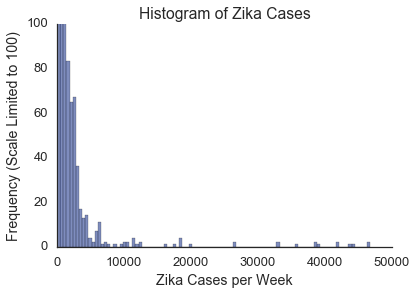

In [60]:
ax = model.zika_cases.hist(bins=100, alpha=0.5)
ax.set_ylim(0,100)
_ = ax.set(xlabel='Zika Cases per Week', 
           ylabel='Frequency (Scale Limited to 100)', 
           title='Histogram of Zika Cases')
ax.grid('off')
sns.despine()

In [61]:
model.shape[0], model.query('zika_cases<=5000').shape[0]

(110719, 110659)

In [62]:
mask = ((model.zika_cases>0) & (model.zika_cases<=5000))
print 'Non-zero entries below 5,000: ', mask.sum()
model = model.loc[model.zika_cases<=5000]

Non-zero entries below 5,000:  14777


Other input variables are shown below. Weather data (temperature, rain, wind) are present for the current week and timeshifted for the two previous weeks, as the lifespan of a mosquito is approximately two weeks. Population density, proximity to airports (both major and any size) as well as location of the closest *Aedes aegypti* mosquito is included in the input data.

In [63]:
model.iloc[0].T

max_temp                67.000000
max_temp1               70.000000
max_temp2               68.000000
mean_temp               53.000000
mean_temp1              57.000000
mean_temp2              56.000000
min_temp                38.000000
min_temp1               43.000000
min_temp2               44.000000
dew_point               41.000000
dew_point1              50.000000
dew_point2              47.000000
precipitation            0.000000
precipitation1           2.050000
precipitation2           2.320000
wind                     4.000000
wind1                    5.000000
wind2                    6.000000
zika_cases               0.000000
density_per_km        1096.302124
airport_dist_any         1.263055
airport_dist_large       1.293253
mosquito_dist           10.017954
Name: 0, dtype: float64

## Logistic Regression

Logistic regression was performed on the ratio of Zika cases per population. I tried a couple different thresholds for the predictor variable. Given the relatively large number of 'zero' values, I'm currently using any occurrence as the definition of an outbreak. Could explore this more, though I'll likely try to switch to `RandomForestClassifier`.

In [64]:
model['zika_ratio'] = model.zika_cases / model.density_per_km

X_cols = [x for x in model.columns if x not in ['zika_cases','zika_bool']]
Y_cols = ['zika_bool']

In [65]:
# thresh = model.zika_ratio.loc[model.zika_ratio>0].quantile(0.02)
thresh = 0

model['zika_bool'] = 0
model.loc[model.zika_ratio>thresh, 'zika_bool'] = 1
model['zika_bool'] = model.zika_bool.astype(int)

print(thresh, model.shape[0], model.zika_bool.sum())

(0, 110659, 14777)


I have some concerns that the above class is a little imbalanced, in particular given the confusion matrix.

In [66]:
train, test = train_test_split(model, test_size=0.30, random_state=42)

Xtrain = normalize(train[X_cols])
Xtest = normalize(test[X_cols])

# Double check that Y-data needs to be normalized
# but I don't think it should hurt the results
Ytrain = normalize(train[Y_cols]).ravel()
Ytest = normalize(test[Y_cols]).ravel()

LR = LogisticRegressionCV(Cs=10, penalty='l2')
#LR = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear')

LR.fit(Xtrain, Ytrain)

Ypred = LR.predict(Xtest)

In [132]:
logistic_cm = confusion_matrix(Ytest, Ypred)
logistic_f1 = f1_score(Ytest, Ypred)
logistic_accuracy = accuracy_score(Ytest, Ypred)

In [133]:
logistic_cm

array([[28699,     0],
       [ 2482,  2017]])

In [134]:
logistic_f1

0.61909146715776553

In [135]:
logistic_accuracy

0.92523646002771254

## Random Forest Classifier

In [125]:
Xtrain = train[X_cols]
Xtest = test[X_cols]

Ytrain = train[Y_cols]
Ytest = test[Y_cols].squeeze()

forest = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1, 
                                random_state=42, verbose=1)

forest.fit(Xtrain, Ytrain.values.ravel())

Ypred = forest.predict(Xtest)
# Ypred = (forest.oob_decision_function_[:,1]>0.5).astype(int)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


In [126]:
confusion_matrix(Ytest, Ypred)

array([[28699,     0],
       [ 2482,  2017]])

In [127]:
roc_auc_score(Ytest, Ypred)

0.72416092464992221

In [128]:
xdata, ydata, _ = roc_curve(Ytest, Ypred)
roc_auc = auc(xdata, ydata)

More input categories are needed? And the classes are too imbalanced..

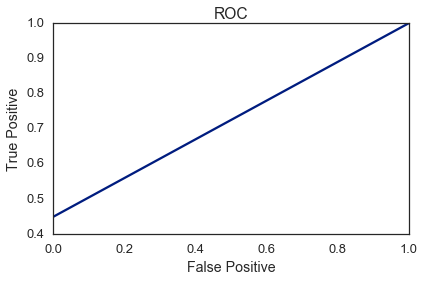

In [143]:
f = plt.figure()
ax = plt.axes()

ax.plot(xdata, ydata)
ax.set(xlabel='False Positive', ylabel='True Positive', title='ROC')
plt.tight_layout()
f.savefig('ROC.png')